In [11]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.special import erf
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.preprocessing import MinMaxScaler




def preprocess(df: pd.DataFrame=None, col_num: int =None, multi_df: dict=None ) :

    #return a whole dataframe that have all the class in
    #multi_df will contain all pd dataframe in each class csv file with the value is the column number in which the class in

    #if the class is specified in column, then move that column into the front
    if df is not None and col_num != None:
        df[col_num] = df[col_num].astype(str)
    if col_num != None and col_num != 0:
        columns = [col_num] + [col for col in df.columns if col != col_num]
        df = df[columns]
        #df = df.reset_index(drop=True)  # Reset the index
        return df
    elif multi_df != None:
        for name, [df_, col] in multi_df.items():
            if col != None:  
                if col != 0:
                    columns = [col_num] + [col for col in df_.columns if col != col_num]
                    df_ = df_[columns]
            else:
                df_.insert(0, "label", name)

        concatenated_df = pd.concat([df for df, _ in multi_df.values()], ignore_index=True)

        return concatenated_df
                
    #concat into a whole file 


    return df





class knn_distinguish():
    def __init__(self, data: pd.DataFrame, predicted_class:list) -> None:
        '''
        data->the combined data, the whole data
        data_origin->the original data, aka the test data
        predicted_class->a bunch of class from data, class name, we assume it's a list
        '''
        # print(len(data))
        self.store_LSE = {}
        self.arctan_popt = {}
        self.logistic_popt = {}
        self.tanh_popt = {}
        self.arc_popt = {}
        self.gd_popt = {}
        self.ERF_popt = {}
        self.algebra_popt = {}
        self.Gompertz_popt = {}
        
        #store for edge case:
        self.arctan_min = {}
        self.logistic_min = {}
        self.tanh_min = {}
        self.arc_min = {}
        self.gd_min = {}
        self.ERF_min = {}
        self.algebra_min = {}
        self.Gompertz_min = {}
        
        self.data = data
        # self.data_origin = data_origin
        self.predicted_class = predicted_class
        self.maxDis_train = 0
        self.df_comb1 = None

    def combine_data(self, data, classes):
        '''
        split the data according to the classes
        '''
        df = pd.DataFrame(data)
        for index, name in enumerate(classes):
            df.loc[df.iloc[:, 0] == name, 'class'] = name
        df = df.drop(df.columns[0], axis=1).drop_duplicates()
        return df
    
    def data_process(self, dataframe, class_name):
        a = dataframe[dataframe['class']==class_name].drop("class",axis=1).astype(float).to_numpy()
        return a

    def data_distance(self, data):
        '''
        calculating empirical data's shortest(NN) distance 
        real data is high-dimensional data points
        '''
        if len(data) == 1:
            return np.array(data)
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)
        distances, _ = nbrs.kneighbors(data)
        shortest_distances = distances[:, 1]
        if not np.any(shortest_distances):
            return np.array([0] * len(data))
        return shortest_distances
    
    def empirical_CDF(self, data):
        '''
        return x,y data of CDF 
        '''   
        sort_data = np.sort(data)
        self.maxDis_train =np.max(sort_data)
        if sort_data.ndim == 1:
            x = np.concatenate(([0],sort_data))
        else:
            x = np.concatenate(([0], sort_data.reshape(-1)))
        y = np.zeros((x.shape))
        for i in range(len(x)):
            y[i] = (len(x)-i-0.5)/len(x)
        return x,y
    
    def auto_curve_fit(self, data_NN, x, y, x_scale_factor, func, s, p_control=None):
        '''
        data_NN: array empirical data_distance for calculating median
        x,y: from CDF
        s: sigma in curve_fit(), for weighting
        '''
        if p_control == "Gompertz":
            p0 = [1,1]
        elif p_control == "Weight":
            p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
        else:
            p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
        
        if not np.any(x):
            try:
                popt, _ = curve_fit(f=func, xdata=x, ydata=y, p0=p0,method='lm')
            except TypeError:
                popt = np.zeros(5)
        else:
            try:
                popt, _ = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')
            except TypeError:
                popt = np.zeros(5)
        return popt
    
    def data_binning(self, data):
        x = np.sort(data) 
        N = len(x)                   # e.g N = 500, sqrt(500)=22.3
        lower = int(np.floor(np.sqrt(N))) # 22
        upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
        
        if lower*upper >= N:
            small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
            small_bin_size = int(lower - 1)  # 21
            large_bin_size = lower
        else: # HGG -> sqrt(252) = 15.8
            small_bin_num = int(upper**2 - N) # 16*16-252 =4
            small_bin_size = lower  # 15
            large_bin_size = upper
        
        large_bin_num = int(upper - small_bin_num) # 23-6 = 17

        # small_bin_size*small_bin_num + lower*large_bin_num = N

        bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
        #print("items in each bin: ", bin_count)
        binned_data = []
        i = 0
        for count in bin_count:
            binned_data.append(np.mean(x[i:i+count]))
            i += count
        
        return binned_data


    def binning_xy(self, binned_data):
        x = np.concatenate(([0],binned_data))
        y = np.zeros((x.shape))
        for i in range(len(x)):
            y[i] = (len(x)-i-0.5)/len(x)
        return x,y
    
    
    def sigmoids_for_class(self, data, name, factor, func_list, binning=False, plot=False): #removed color list here
        plot = True
        if binning:
            x,y = self.binning_xy(self.data_binning(data))
        else:
            x,y = self.empirical_CDF(data)
        if plot:
            color_list = ['g','r','c','m','y','k','brown','gray']
            f,ax = plt.subplots(1,2,figsize=(16,6))
            ax[0].set_title('1-y(p_value) of '+ str(name))
            ax[0].set_yscale('log')
            ax[0].scatter(x,1-y, color='b',s=10)

            ax[1].set_title('y of '+name)
            ax[1].scatter(x,y, color='b',s=10)
        res = []
        #print("for ", name," :")
        for i in range(len(func_list)):
            try:
                if i == 7:
                    p = self.auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")
                elif i == 6:
                    p = self.auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
                else:
                    p = self.auto_curve_fit(data,x,y,factor,func_list[i],s=y)
            except RuntimeError:
                print("error in ",str(func_list[i])[9:-22])
                continue
            smoothing_term = 1e-10
            if np.array_equal(p, np.zeros(5)):
                y2 = 0
                y_true = 1-y + smoothing_term
                y_true_filtered = y_true[y_true > 0]
                error = np.sum(np.square(np.log(y_true_filtered + smoothing_term)))
            else:
                y2 = func_list[i](x/factor, *p)
                y_pred = y2
                y_true = y
                y_pred_filtered = y_pred[y_pred > 0]
                y_true_filtered = y_true[y_pred > 0]
                error = np.sum(np.square(np.log(y_pred_filtered + smoothing_term) - np.log(y_true_filtered + smoothing_term)))

            if func_list[i] == self.arctan_GD:
                self.arctan_popt[f"{name}"] = p
                self.arctan_min[f"{name}"] = np.min(y2)
                self.store_LSE["arctan_gd"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='arctan_GD')
                    ax[1].plot(x, y2, color=color_list[i], label='arctan_GD')
                # print(np.min(y2))
                res.append([func_list[i], *p])
            if func_list[i] == self.logistic:
                self.logistic_popt[f"{name}"] = p
                self.logistic_min[f"{name}"] = np.min(y2)
                self.store_LSE["logistic"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='logistic')
                    ax[1].plot(x, y2, color=color_list[i], label='logistic')
                res.append([func_list[i], *p])
            if func_list[i] == self.tanh:
                self.tanh_popt[f"{name}"] = p
                self.tanh_min[f"{name}"] = np.min(y2)
                self.store_LSE["Hyperbolic tangent"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='Hyperbolic tangent')
                    ax[1].plot(x, y2, color=color_list[i], label='Hyperbolic tangent')
                res.append([func_list[i], *p])
            if func_list[i] == self.arctan:
                self.arc_popt[f"{name}"] = p
                self.arc_min[f"{name}"] = np.min(y2)
                self.store_LSE["arctan"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='arctan')
                    ax[1].plot(x, y2, color=color_list[i], label='arctan')
                res.append([func_list[i], *p])
            if func_list[i] == self.GD:
                self.gd_popt[f"{name}"] = p
                self.gd_min[f"{name}"] = np.min(y2)
                self.store_LSE["Gudermannian"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='Gudermannian')
                    ax[1].plot(x, y2, color=color_list[i], label='Gudermannian')
                res.append([func_list[i], *p])
            if func_list[i] == self.ERF:
                self.ERF_popt[f"{name}"] = p
                self.ERF_min[f"{name}"] = np.min(y2)
                self.store_LSE["ERF"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='ERF')
                    ax[1].plot(x, y2, color=color_list[i], label='ERF')
                res.append([func_list[i], *p])
            if func_list[i] == self.algebra:
                self.algebra_popt[f"{name}"] = p
                self.algebra_min[f"{name}"] = np.min(y2)
                self.store_LSE["algebraic"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='algebraic')
                    ax[1].plot(x, y2, color=color_list[i], label='algebraic')
                res.append([func_list[i], *p])
            if func_list[i] == self.Gompertz:
                self.Gompertz_popt[f"{name}"] = p
                self.Gompertz_min[f"{name}"] = np.min(y2)
                self.store_LSE["Gompertz"] = error
                if plot:
                    ax[0].plot(x, 1-y2, color=color_list[i], label='Gompertz')
                    ax[1].plot(x, y2, color=color_list[i], label='Gompertz')
                res.append([func_list[i], *p])
        if plot:
            ax[0].legend(loc='lower left')
            ax[1].legend(loc='lower left')
            plt.show()
        return res


    def logistic(self, x,x0, k):
        m = (1/ (1 + np.exp(-k*(x-x0))))     
        return np.clip(m, 1e-14, 1 - 1e-14)

    def tanh(self, x, x0, k): 
        m = (1+np.tanh(k*(x-x0)))/2    
        return np.clip(m, 1e-14, 1 - 1e-14)

    def arctan(self, x, x0, k):
        m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
        return np.clip(m, 1e-14, 1 - 1e-14)

    def GD(self, x, x0, k):
        m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
        return np.clip(m, 1e-14, 1 - 1e-14)

    def ERF(self, x, x0, k):
        m = (1+erf(k*(x-x0)))/2
        return np.clip(m, 1e-14, 1 - 1e-14)

    def algebra(self, x, x0, k):
        abs_x = abs(x)
        denominator = (1 + abs_x ** k) ** (1/k)
        m = (1 + x / denominator) / 2
        # m = (1+x/((1+abs(x)**k)**(1/k)))/2
        if np.any(denominator == 0):
            m[denominator == 0] = 0
        return np.clip(m, 1e-14, 1 - 1e-14)

    def arctan_GD(self, x,x0,k, w):
        m = w*self.GD(x,x0,k)+(1-w)*self.arctan(x,x0,k)
        return np.clip(m, 1e-14, 1 - 1e-14)

    def Gompertz(self, x,b,c):
        m = np.e**(-np.e**(b-c*x))
        return np.clip(m, 1e-14, 1 - 1e-14)
        
    def build_AM(self, x, y):
        """Function to build the A matrix in parallel.

        Keyword arguments:
        x -- the input data numpy array in the form nxm (samplesxfeatures).
        y -- the numpy array that represents the classes for each sample.
        """
        def build_cm(feat):
            cm = []
            for lab in np.unique(y):
                x_fit = x[np.where(y == lab)[0], feat].reshape(-1, 1)
                # print(len(self.data)//10)
                # print(len(self.predicted_class)*2)
                params = {'bandwidth': np.linspace(0.01, 0.99, 100)}
                # print("done1")
                grid = GridSearchCV(KernelDensity(), params, cv=4)
                # print("done2")
                grid.fit(x_fit)
                kde = grid.best_estimator_
                a = np.exp(kde.score_samples(x_fit))
                cm.extend(a.tolist())
            return np.array(cm, dtype=object).flatten()

        bm = Parallel(n_jobs=-1)(delayed(build_cm)(feat) for feat in range(x.shape[1]))
        bm = np.array(bm).T
        # print(bm)
        return bm



    def distanceValue(self, test_data: pd.DataFrame, sigmoid_function, sigmoid_popt, df_combine, edge_dict):

        nearest_NN = []
        sigmoid_val = []

        for target in sigmoid_popt:
            distances = pairwise_distances(test_data.to_numpy(), df_combine[df_combine['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy(), metric='euclidean')
            nearDis = np.min(distances)
            nearest_NN.append(nearDis)
            # if sigmoid_function(nearDis, *sigmoid_popt[f'{target}']) == 0 and edge_dict != {}:
            #     nearDis = self.maxDis_train
            #     sigmoid_val.append(edge_dict[f'{target}'])
            # else:
            sigmoid_val.append(sigmoid_function(nearDis, *sigmoid_popt[f'{target}']))
        return [sigmoid_val, nearest_NN]

    def helper_plot_curve(self, final_list, nearest_nn, sigmoid_val):
        popt_list = [v for v in final_list[1].values()]
        for i in range(len(popt_list)):
            plt.title(self.predicted_class[i])
            x = np.linspace(0, nearest_nn[i]+1, 100)
            y = final_list[0](x, *popt_list[i])
            plt.plot(x, y, label="train sigmoid")
            print("nearDis: ", nearest_nn)
            print("sigmoid Val: ", sigmoid_val)
            plt.scatter(nearest_nn[i], sigmoid_val[i], label="test point", c='red')
            plt.legend()
            plt.show()

    def fit(self, if_binning=False, plot=False):
        df_comb = self.combine_data(self.data, self.predicted_class)
        self.df_comb1 = df_comb
        final_list = []
        df_class = df_comb['class']
        mpVal = {}
        for i, v in enumerate(self.predicted_class):
            mpVal[v] = i+1
        X = df_comb.iloc[:, :-1].values
        y = df_comb.iloc[:, -1].values
        df_comb = self.build_AM(X, y)
        df_comb = pd.DataFrame(df_comb)
        df_comb = pd.DataFrame(df_comb, columns=list(df_comb.columns) + ['class'])
        df_comb['class'] = df_class.reset_index(drop = True)
        functions = [ self.logistic, self.tanh, self.arctan, self.GD, self.ERF, self.algebra, self.arctan_GD, self.Gompertz]
        for i in range(len(self.predicted_class)):
            processed_data = self.data_distance(self.data_process(df_comb, self.predicted_class[i]))
            # print(np.max(processed_data))
            #[func, *p]
            final_dict = self.sigmoids_for_class(processed_data, self.predicted_class[i], np.mean(processed_data), functions, binning=if_binning, plot=plot)
            # print(final_dict)
            final_list.append(final_dict)
            # print(final_dict)
        # print(self.store_MSE)
        sorted_sigmoid = sorted(self.store_LSE.items(), key=lambda x:x[1])
        #print(sorted_sigmoid)
        sig_function = sorted_sigmoid[0][0]
        if sig_function == "arctan_gd":
            return [self.arctan_GD, self.arctan_popt, self.arctan_min]
        if sig_function == "ERF":
            return [self.ERF, self.ERF_popt, self.ERF_min]
        if sig_function == "arctan":
            return [self.arctan, self.arc_popt, self.arc_min]
        if sig_function == "logistic":
            return [self.logistic, self.logistic_popt, self.logistic_min]
        if sig_function == "Hyperbolic tangent":
            return [self.tanh, self.tanh_popt, self.logistic_min]
        if sig_function == "Gudermannian":
            return [self.GD, self.gd_popt, self.gd_min]
        if sig_function == "algebraic":
            return [self.algebra, self.algebra_popt, self.algebra_min]
        if sig_function == "Gompertz":
            return [self.Gompertz, self.Gompertz_popt, self.Gompertz_min]
        
    def predict(self, test_data: pd.DataFrame, sig_function, sig_popt: np.ndarray, edgecase=None):
        val = []
        if edgecase != None:
            edge_dict = edgecase
        else:
            edge_dict = {}
        
        val = self.distanceValue(test_data, sig_function, sig_popt, self.df_comb1, edge_dict)[0]
        nearest_NN = self.distanceValue(test_data, sig_function, sig_popt, self.df_comb1, edge_dict)[1]
        print(f"nearest NN" + str(nearest_NN))

        print(f"sigmoid value" + str(val))

        print(str(sig_function))
        final_list = [sig_function, sig_popt]
        print(sig_popt)
        self.helper_plot_curve(final_list, nearest_NN, val)
        
        return val


--------Iris---------
[[0.9332658904489086 0.8666795306478438 1.8773754475358035
  11.694896646488392]
 [0.904637171348801 0.5876175477993636 1.8773754475358035
  11.694896646488392]
 [0.6972800706056372 0.8179630310395472 1.4076378891593326
  11.694896646488392]
 [0.5827208535664873 0.7161602667508462 1.9041862926710365
  11.694896646488392]
 [0.9523516575408658 0.7962395681307247 1.8773754475358035
  11.694896646488392]
 [0.5930618692321395 0.4775900921010281 0.9179318465058681
  2.923731357150329]
 [0.5827208535664873 0.8971781987142139 1.8773754475358035
  2.9237683627241]
 [0.9523516575408658 0.8971781987142139 1.9041862926710365
  11.694896646488392]
 [0.3631989539480534 0.4484266793481445 1.8773754475358035
  11.694896646488392]
 [0.904637171348801 0.7161602667508462 1.9041862926710365
  1.670735743313937]
 [0.5930618692321395 0.698655944118255 1.9041862926710365
  11.694896646488392]
 [0.8105024724970673 0.8971781987142139 1.4870673862980515
  11.694896646488392]
 [0.8105024724

/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


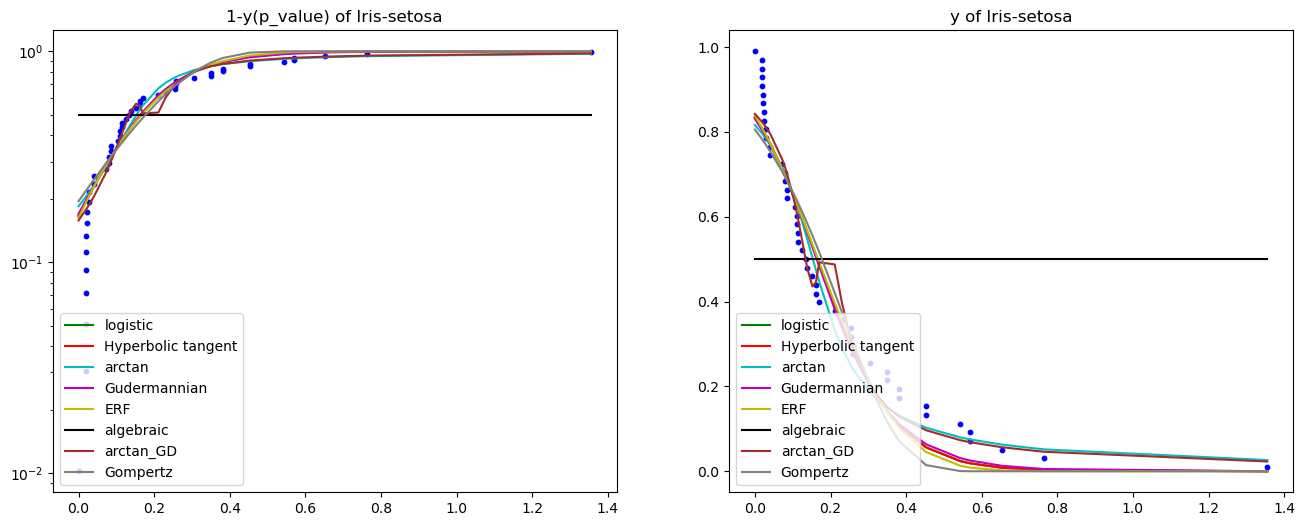

/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


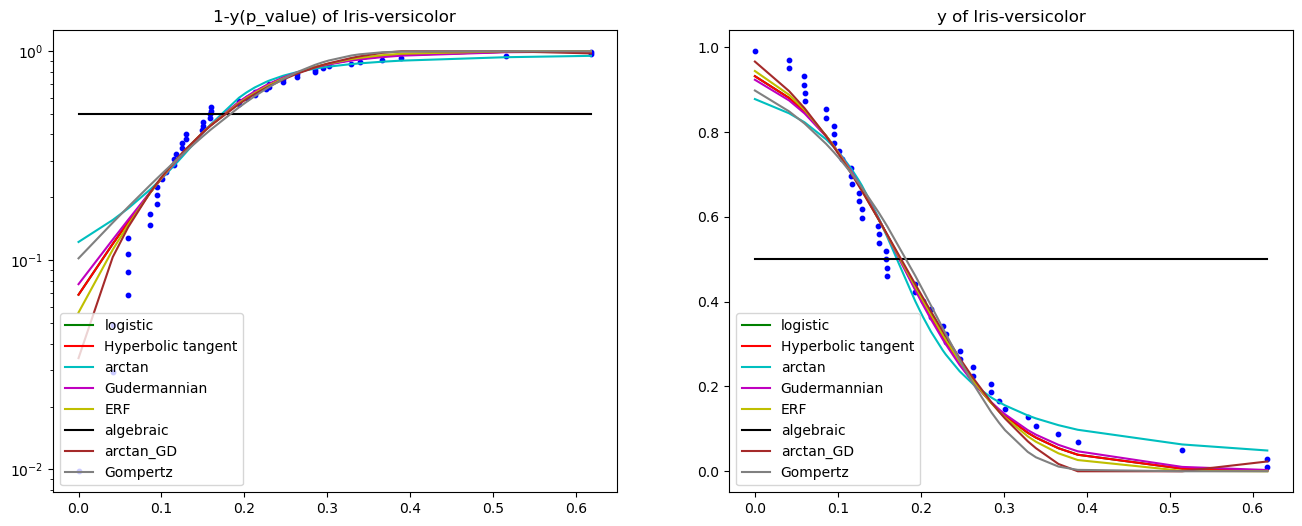

/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


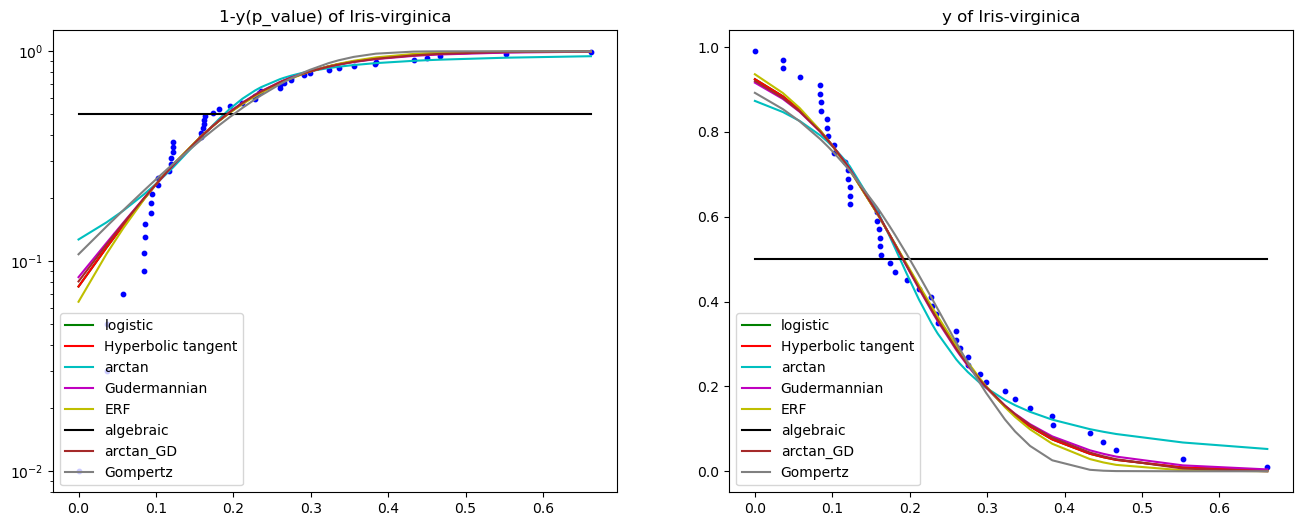

nearest NN[3.6715119501371656, 0.36055512754641234, 1.1920928955078125e-07]
sigmoid value[0.003090525360212981, 0.8200676367172829, 0.9159802160479942]
<bound method knn_distinguish.GD of <__main__.knn_distinguish object at 0x7fce8d1c0c40>>
{'Iris-setosa': array([ 0.71977486, -0.90248953]), 'Iris-versicolor': array([ 0.87205295, -1.20866192]), 'Iris-virginica': array([ 0.8831321 , -1.14325523])}
nearDis:  [3.6715119501371656, 0.36055512754641234, 1.1920928955078125e-07]
sigmoid Val:  [0.003090525360212981, 0.8200676367172829, 0.9159802160479942]


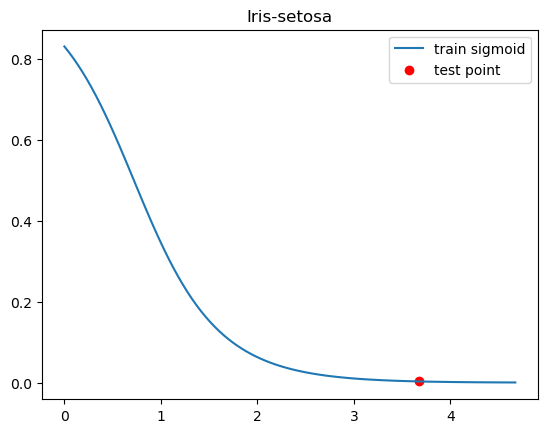

nearDis:  [3.6715119501371656, 0.36055512754641234, 1.1920928955078125e-07]
sigmoid Val:  [0.003090525360212981, 0.8200676367172829, 0.9159802160479942]


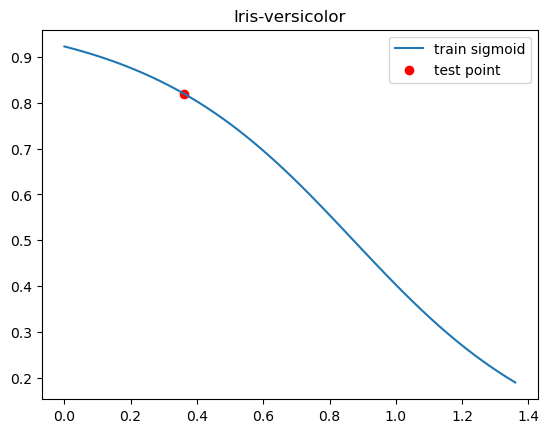

nearDis:  [3.6715119501371656, 0.36055512754641234, 1.1920928955078125e-07]
sigmoid Val:  [0.003090525360212981, 0.8200676367172829, 0.9159802160479942]


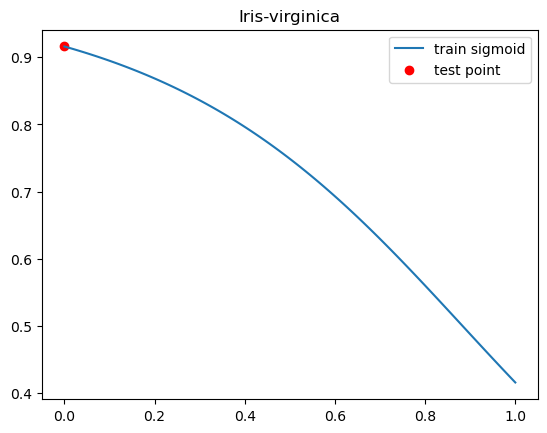

[0.003090525360212981, 0.8200676367172829, 0.9159802160479942]


In [12]:
print("--------Iris---------")
# data_lst = []
#classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
df_origin = pd.read_csv("../data/Iris/Iris-Original", header=None, sep=',')
df_oo = pd.read_csv("../data/Iris/Iris-test", header=None, sep=',')
# last_col = df_origin.iloc[:, -1]

# df_oo = df_oo.drop(df_oo.columns[4], axis=1)
#print(df_oo)
# # Select all but the last column and move it to the first position
# df_new = pd.concat([last_col, df_origin.iloc[:, :-1]], axis=1)
# cols = list(df_origin.columns)
# print(cols)
# cols = [cols[-1]] + cols[:-1]
# df_new = df_origin[cols]
#classes = df_origin[4].unique()
df_new = preprocess(df_origin, 4, None)
classes =  df_new[4].unique()
#print(df_new)
# print(df_new)
# print(classes)
knn_iris = knn_distinguish(df_new, classes)

knn_iris_fit = knn_iris.fit()
print(knn_iris.predict(df_oo, knn_iris_fit[0], knn_iris_fit[1]))
# df_origin

--------Wine---------
[[0.5135501722750243 1.3108730649669522 1.483234082314792 ...
  3.64956357972783 0.16170866191052716 0.013660107305855604]
 [0.4624994521452452 1.301453856629673 0.8177743347062522 ...
  3.7898611685131427 0.8949328722803993 0.006830073400677842]
 [0.43777846158407785 0.14049094615817312 1.0895277280866698 ...
  3.379818761768641 0.6846795835259489 0.006830053652927801]
 ...
 [0.5972403388255527 0.21721339959392563 1.7765018576913842 ...
  2.7059706127389314 1.175069113301381 0.008395298554999852]
 [0.6026828358468879 0.2824634950694945 2.0531821488464175 ...
  2.774808503951253 1.2116561281627225 0.008395274281723751]
 [0.18793127750227398 0.24435163330158724 0.8634126316467423 ...
  2.823432244064025 1.204165926399182 0.016790500016895308]]


/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


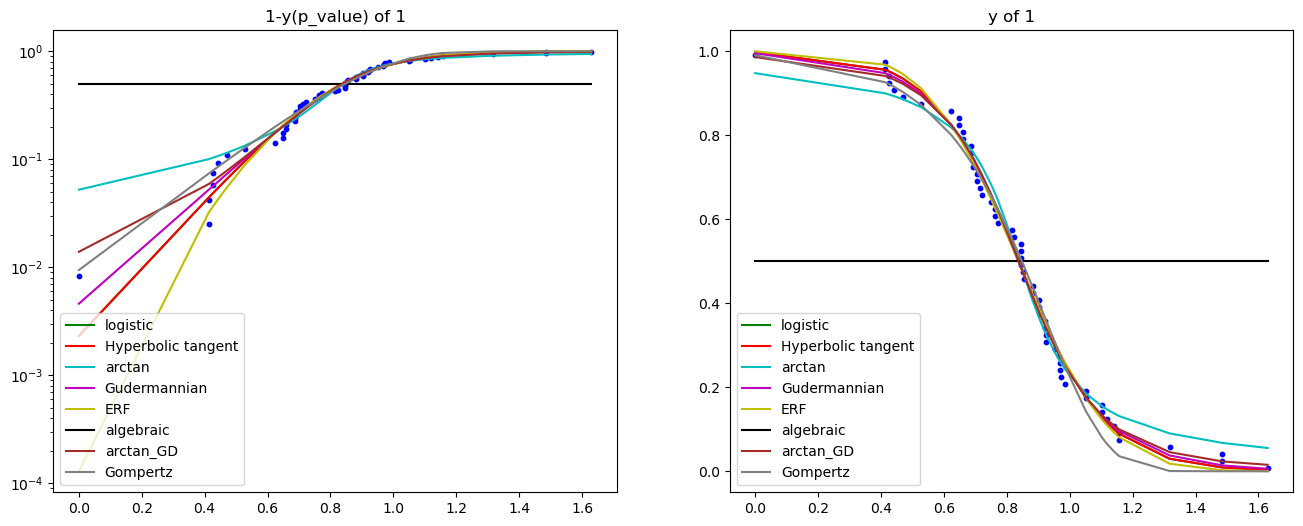

/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


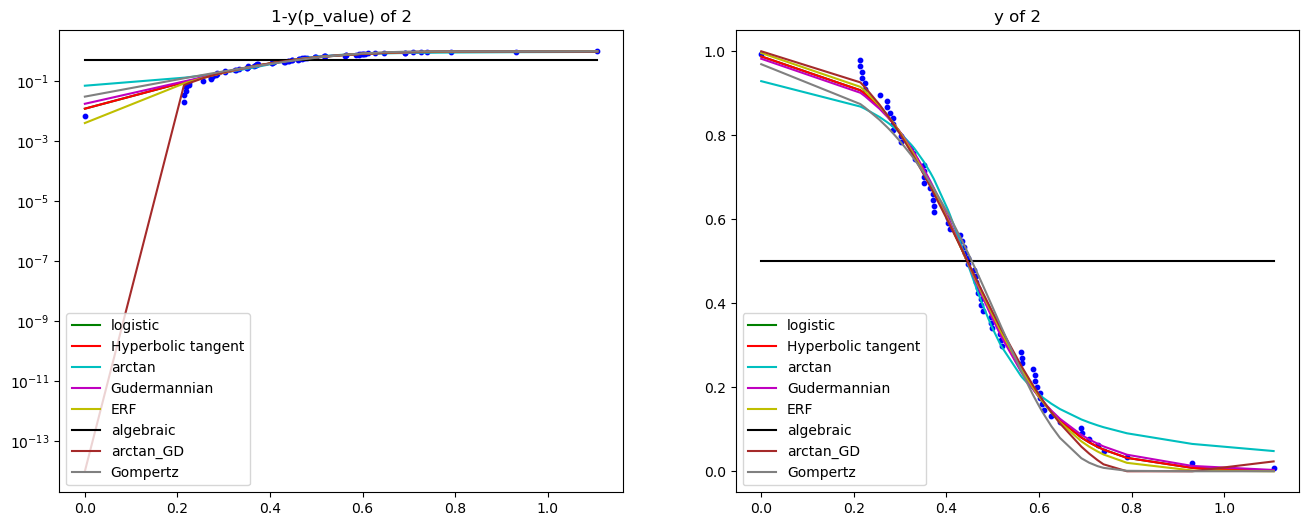

/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


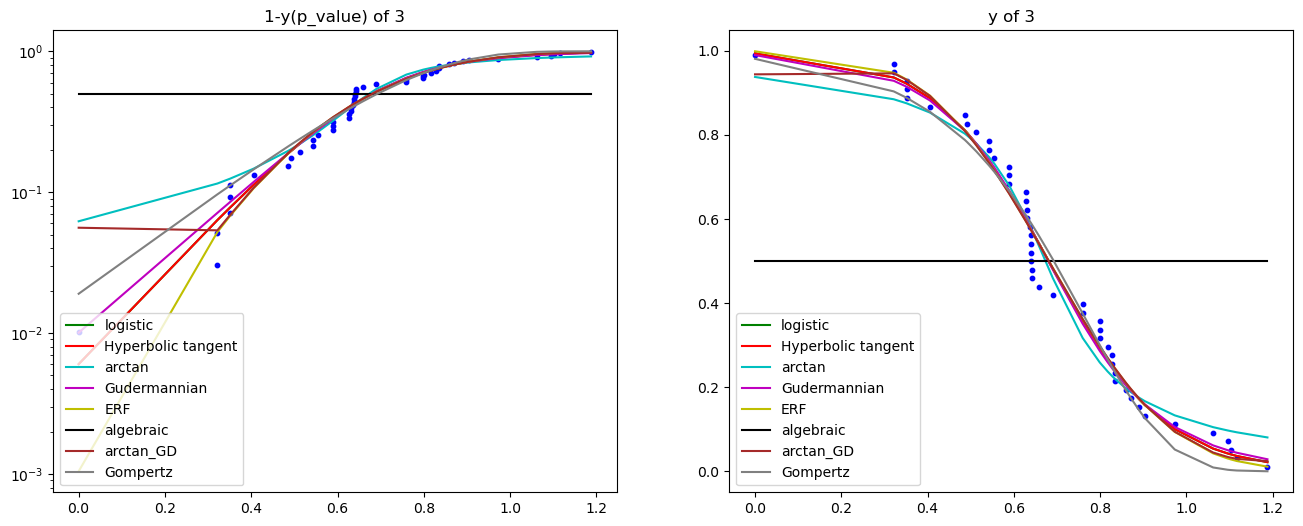

nearest NN[0.0, 82.2120076387866, 187.82095969300136]
sigmoid value[0.9976880507200023, 1e-14, 1e-14]
<bound method knn_distinguish.tanh of <__main__.knn_distinguish object at 0x7fce8d21baf0>>
{'1': array([ 0.97789021, -3.10226525]), '2': array([ 0.96075413, -2.28692002]), '3': array([ 0.97606973, -2.61595334])}
nearDis:  [0.0, 82.2120076387866, 187.82095969300136]
sigmoid Val:  [0.9976880507200023, 1e-14, 1e-14]


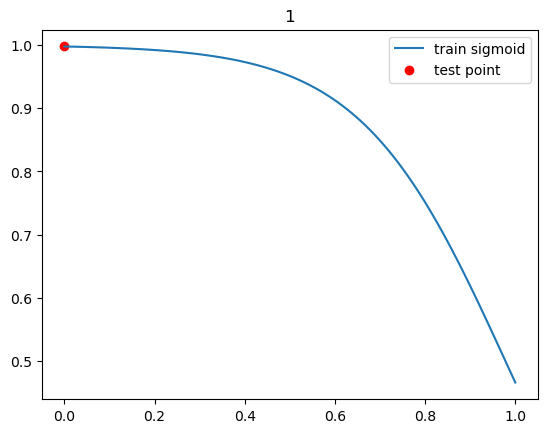

nearDis:  [0.0, 82.2120076387866, 187.82095969300136]
sigmoid Val:  [0.9976880507200023, 1e-14, 1e-14]


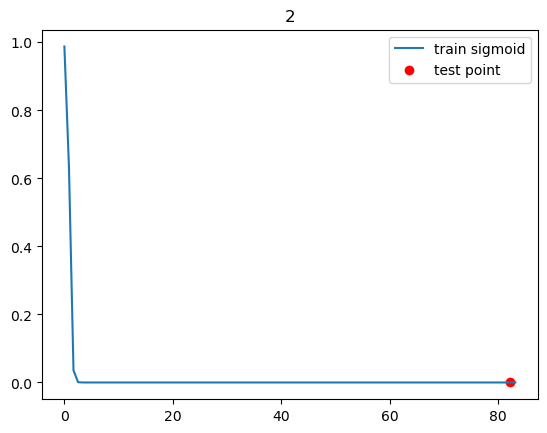

nearDis:  [0.0, 82.2120076387866, 187.82095969300136]
sigmoid Val:  [0.9976880507200023, 1e-14, 1e-14]


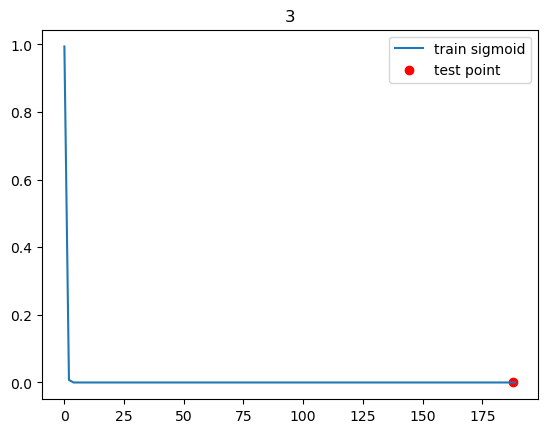

[0.9976880507200023, 1e-14, 1e-14]


In [13]:
print("--------Wine---------")
# data_lst = []
#classes = ['1', '2', '3']
# # classes_pred = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# data_locations = [r"../data/Iris/Iris-"+c for c in classes]
# for i in data_locations:
#     pd1 = pd.read_csv(i, header=None, sep=',')
#     pd1 = pd1.drop(pd1.columns[-1], axis=1)
#     data_lst.append(pd1)
df_origin_wine = pd.read_csv("../data/wine/wine", header=None, sep=',')
df_oo_wine = pd.read_csv("../data/wine/wineOriginal", header=None, sep=',')
# last_col = df_origin.iloc[:, -1]

# df_oo_wine= df_oo_wine.drop(df_oo_wine.columns[0], axis=1)

#classes2 = df_origin_wine[0].unique()

df_new_wine = preprocess(df_origin_wine, 0)
classes = df_origin_wine[0].unique()

# # Select all but the last column and move it to the first position
# df_new = pd.concat([last_col, df_origin.iloc[:, :-1]], axis=1)
# print(df_origin_wine)

knn_wine = knn_distinguish(df_new_wine, classes)
knn_wine_fit = knn_wine.fit()
print(knn_wine.predict(df_oo_wine, knn_wine_fit[0], knn_wine_fit[1]))

-----------------test heart-----------------
[[0.055631501825138346 0.06309426453505707 0.018954278430126034 ...
  0.09626688991191534 0.05212119757408643 0.038709190341398164]
 [0.055631501825138346 0.06309426453505707 0.07337864444945254 ...
  0.041327210472004564 0.06068709021369414 0.06378196810448968]
 [0.042017855643225924 0.05020710086957211 0.08365725966174453 ...
  0.04959257526757903 0.012908410916010762 0.06378196810448968]
 ...
 [0.04033427264157859 0.039097103269134924 0.07678779683113819 ...
  0.010176472335222663 0.010077172877182551 0.016122953007644138]
 [0.06128523167032105 0.039097103269134924 0.016338730763532566 ...
  0.017539993736783173 0.03426692153172115 0.02015832688648792]
 [0.06128523167032105 0.06630788460274749 0.06370612095189997 ...
  0.011386324888279634 0.02620874480548683 0.022381667048559168]]


/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


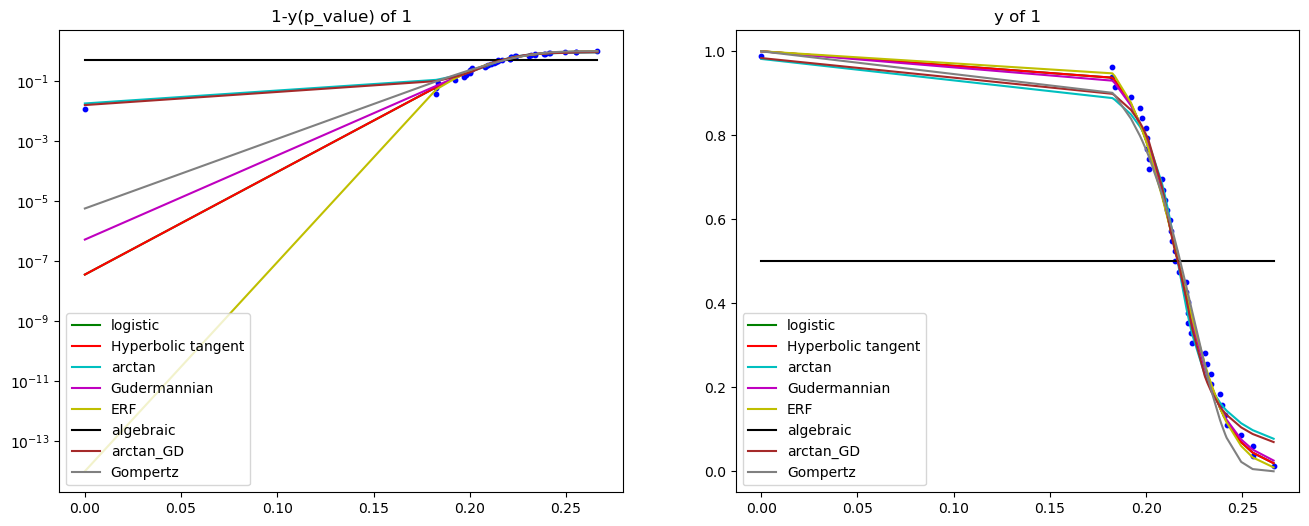

/tmp/ipykernel_3643911/2425690300.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_3643911/2425690300.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


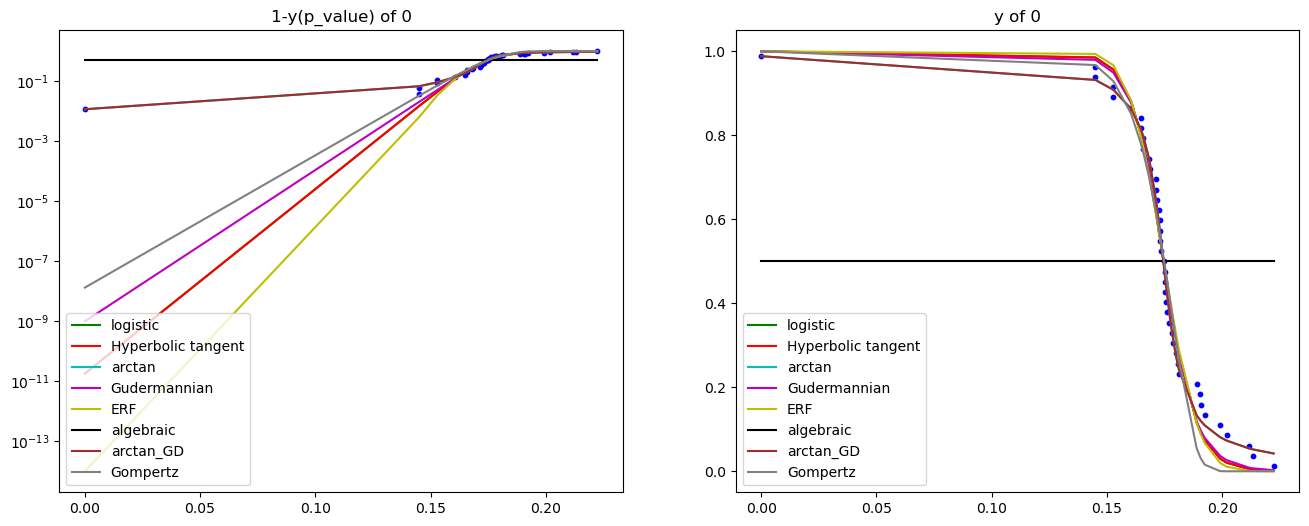

nearest NN[46.776062254106, 62.185207244167]
sigmoid value[0.0003489430856541242, 0.0001885627816026473]
<bound method knn_distinguish.arctan_GD of <__main__.knn_distinguish object at 0x7fce8d04b160>>
{'1': array([  0.99158712, -33.25352185,  -0.66901569]), '0': array([  0.98667944, -28.69191607,  -0.04017503])}
nearDis:  [46.776062254106, 62.185207244167]
sigmoid Val:  [0.0003489430856541242, 0.0001885627816026473]


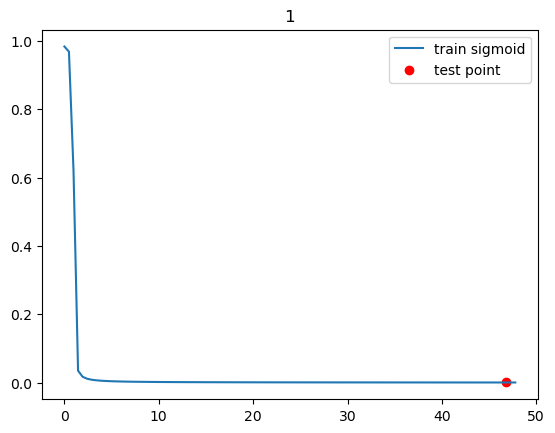

nearDis:  [46.776062254106, 62.185207244167]
sigmoid Val:  [0.0003489430856541242, 0.0001885627816026473]


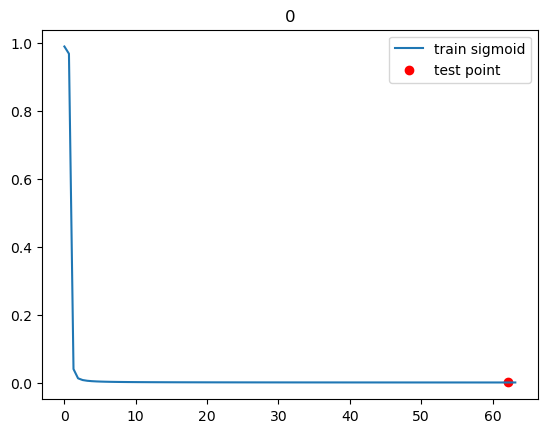

[0.0003489430856541242, 0.0001885627816026473]


In [14]:
print("-----------------test heart-----------------")
df_train_heart = pd.read_csv("../data/SPECT/SPECTF.train", header=None, sep=',')
df_test_heart = pd.read_csv("../data/SPECT/SPECTF.test", header=None, sep=',')

df_test_heart =  df_test_heart.drop(df_test_heart.columns[0], axis=1)
# print(df_test)
# last_col = df_train.iloc[:, -1]
# # Select all but the last column and move it to the first position
# df_new = pd.concat([last_col, df_train.iloc[:, :-1]], axis=1)
df_new_train_heart = preprocess(df_train_heart, 0)
class_heart = df_new_train_heart[0].unique()
# print(df_train.shape)
# print(df_test.shape)
# df_new[0] = df_new[0].astype(str)
knn_heart = knn_distinguish(df_new_train_heart, class_heart)
knn_heart_fit = knn_heart.fit()
print(knn_heart.predict(df_test_heart.iloc[[20]], knn_heart_fit[0], knn_heart_fit[1]))

In [35]:
print("-----------------test spam-----------------")
df_train_spam = pd.read_csv("../data/spambase/spambase.data", header=None, sep=',')
#class_spam = ['1', '0']
df_test_spam = pd.read_csv("../data/spambase/test.csv", header=None, sep=',')
# print(df_test.shape)
# df_train.iloc[:, -1] = df_train.iloc[:, -1].astype(str)
# last_col = df_train.iloc[:, -1]
# # print(df_test.iloc[0].dtype)
# # Select all but the last column and move it to the first position
# df_new = pd.concat([last_col, df_train.iloc[:, :-1]], axis=1)

#print(df_train[57].unique())

df_new_train_spam = preprocess(df_train_spam, 57)
classes = df_new_train_spam[57].unique()


knn_spam = knn_distinguish(df_new_train_spam, classes)
knn_spam_fit = knn_spam.fit()
print(knn_spam.predict(df_test_spam, knn_spam_fit[0], knn_spam_fit[1]))

#print(df_new_train_spam)
#print(classes)
# df_new[0] = df_new[0].astype(str)
# test_spam = knn_distinguish(df_new, df_test, class_spam)
# #print(test_spam.helper_plot_curve())
# print(test_spam.getPvalue())

-----------------test spam-----------------


KeyboardInterrupt: 

-----------Winequality---------


C:\Users\trand\AppData\Local\Temp\ipykernel_43176\3554450501.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
C:\Users\trand\AppData\Local\Temp\ipykernel_43176\3554450501.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
c:\Users\trand\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


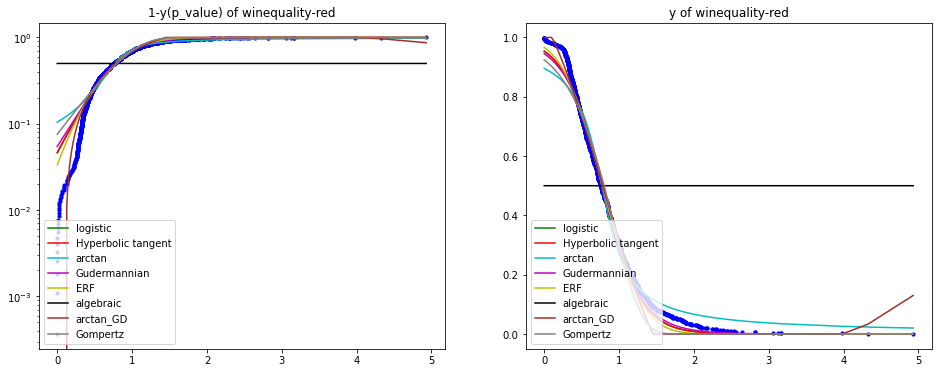

C:\Users\trand\AppData\Local\Temp\ipykernel_43176\3554450501.py:327: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
C:\Users\trand\AppData\Local\Temp\ipykernel_43176\3554450501.py:328: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
c:\Users\trand\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


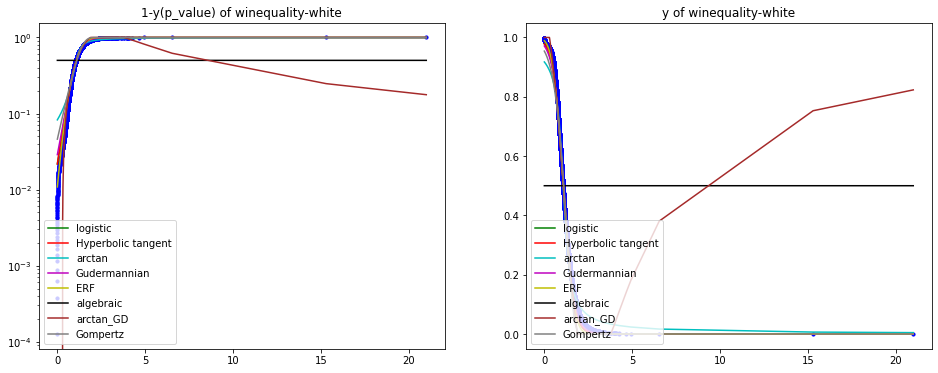

nearest NN[6.743495761743046e-07, 5.795301252704668]
sigmoid value[0.8955826746015509, 0.016203699485995093]
<bound method knn_distinguish.arctan of <__main__.knn_distinguish object at 0x0000020EB3ABC580>>
{'winequality-red': array([ 0.91585639, -3.20825782]), 'winequality-white': array([ 0.93366674, -4.03718151])}
nearDis:  [6.743495761743046e-07, 5.795301252704668]
sigmoid Val:  [0.8955826746015509, 0.016203699485995093]


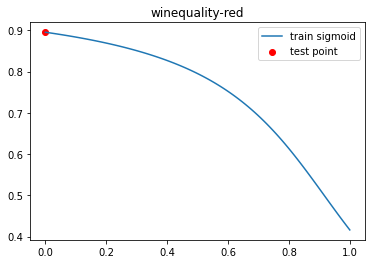

nearDis:  [6.743495761743046e-07, 5.795301252704668]
sigmoid Val:  [0.8955826746015509, 0.016203699485995093]


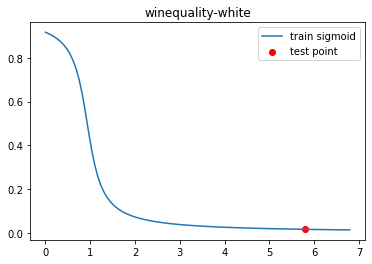

[0.8955826746015509, 0.016203699485995093]


In [192]:
print("-----------Winequality---------")
data_lst = []
df_red = pd.read_csv("C:/Users/trand/knnResearch/Adaptable-Sigmoids/data/wine_quality/winequality-red.csv", header=None, sep=';', skiprows=1)
df_white = pd.read_csv("C:/Users/trand/knnResearch/Adaptable-Sigmoids/data/wine_quality/winequality-white.csv", header=None, sep=';', skiprows=1)
df_test_winequality = pd.read_csv("C:/Users/trand/knnResearch/Adaptable-Sigmoids/data/wine_quality/winequality-original", header=None, sep=';')

multi_df = {'winequality-red': [df_red, None], 'winequality-white': [df_white, None] }
classes = ['winequality-red', 'winequality-white']
df_new_train_winequality = preprocess(None, None, multi_df)


knn_winequality = knn_distinguish(df_new_train_winequality, classes)
knn_winequality_fit = knn_winequality.fit()
print(knn_winequality.predict(df_test_winequality.iloc[[450]], knn_winequality_fit[0], knn_winequality_fit[1]))


In [203]:
print("------------------test accelerator--------------")
df_train_acc = pd.read_csv("C:/Users/trand/knnResearch/Adaptable-Sigmoids/data/accelerometer/accelerometer.csv", header=None, sep=',')
df_test = pd.read_csv("C:/Users/trand/knnResearch/Adaptable-Sigmoids/data/accelerometer/accelerometer_original.csv", header=None, sep=',')

df_test = df_test.drop(df_test.columns[0], axis=1)

df_train_acc_new = preprocess(df_train_acc, 0, None)
classes = df_train_acc_new[0].unique()

knn_acc = knn_distinguish(df_train_acc_new, classes)
knn_acc_fit = knn_acc.fit()
print(knn_acc.predict(df_test.iloc[[20]], knn_acc_fit[0], knn_acc_fit[1]))

#print(df_train_acc_new)

------------------test accelerator--------------
